In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib import rcParams
from matplotlib.lines import Line2D
import sympy

# sys.path.insert(0, '../generation/')
import esr.generation.simplifier as simplifier

# sys.path.insert(0, '../fitting/')
import esr.fitting.test_all as test_all
import esr.fitting.fit_single as fit_single
from sympy_symbols import *
from likelihood import CCLikelihood

rcParams['text.usetex'] = True

In [2]:
# print('Making Pantheon Likelihood')
# panth_like = PanthLikelihood()
print('Making CC Likelihood')
cc_like = CCLikelihood()

Making CC Likelihood


7.2770992084799095 [1481.70861373 3164.02219274    0.            0.        ]
0.0 7.677249887298409


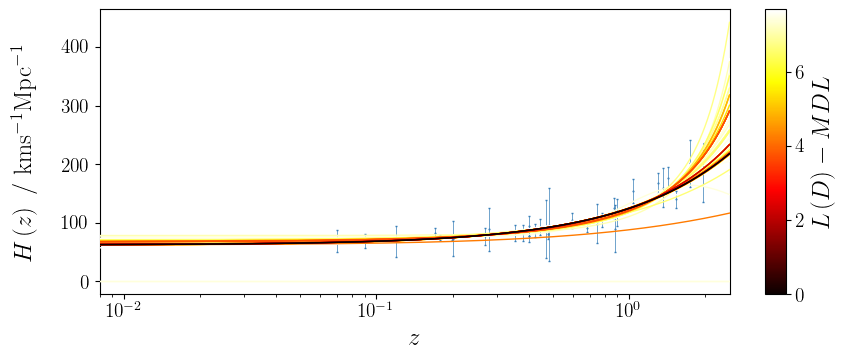

In [20]:
def data_comparison(likelihood, all_compl, xplot, nfun, ylabel1, ylabel2, savename):
    
    rcParams['font.size'] = 14

    tmax = 5
    
    likelihood.clear_data()

    # GET LCDM FUNCTION
    fcn_i = 'a0 * pow(x, 3) + a1'
    fcn_i, eq, integrated = likelihood.run_sympify(fcn_i, tmax=tmax, try_integration=False)

    if 'a3' in fcn_i:
        k = 4
        eq_numpy = sympy.lambdify([x, a0, a1, a2, a3], eq, modules=["numpy"])
    elif 'a2' in fcn_i:
        k = 3
        eq_numpy = sympy.lambdify([x, a0, a1, a2], eq, modules=["numpy"])
    elif 'a1' in fcn_i:
        k = 2
        eq_numpy = sympy.lambdify([x, a0, a1], eq, modules=["numpy"])
    elif 'a0' in fcn_i:
        k = 1
        eq_numpy = sympy.lambdify([x, a0], eq, modules=["numpy"])
    else:
        k = 0
        eq_numpy = sympy.lambdify([x], eq, modules=["numpy"])

    chi2, p = test_all.optimise_fun(fcn_i, likelihood, tmax, 0, 4, try_integration=False)
    print(chi2, p)

    likelihood.clear_data()
    ylcdm_var = likelihood.get_pred(likelihood.xvar, p[:k], eq_numpy, integrated=integrated)
    likelihood.clear_data()
    ylcdm_plot = likelihood.get_pred(xplot, p[:k], eq_numpy, integrated=integrated)

    # GET OTHER FUNCTIONS
    fcn_list = []
    all_DL = []
    params = []

    for i, compl in enumerate(all_compl):
        fname = likelihood.out_dir + '/final_%i.dat'%compl
        with open(fname, "r") as f:
            reader = csv.reader(f, delimiter=';')
            data = [row for row in reader]
        fcn_list += [d[1] for d in data]
        all_DL += [d[2] for d in data]
        params += [d[7:] for d in data]

    all_DL = np.array(all_DL, dtype=float)
    params = np.array(params, dtype=float)
    m = np.isfinite(all_DL)
    all_DL = all_DL[m]
    params = params[m,:]
    fcn_list = [fcn_list[i] for i in range(len(fcn_list)) if m[i]]
    MDL = np.amin(all_DL)

    # Take top nfun functions
    idx = np.argsort(all_DL)[:min(nfun, len(all_DL))]
    all_DL = all_DL[idx] - MDL
    params = params[idx,:]
    fcn_list = [fcn_list[i] for i in idx]

    fig  = plt.figure(figsize=(7,3))
    ax1  = fig.add_axes([0.0,0.0,0.9,0.95])
    ax3  = fig.add_axes([0.95,0.00,0.03,0.95])

    cmap = mpl.cm.hot
    vmin = all_DL.min()
    vmax = all_DL.max()    
    norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
    print(all_DL.min(), all_DL.max())

    max_param = 4
    tmax = 5
    
    likelihood.clear_data()
    
    for i in range(len(fcn_list)):

        fcn_i = fcn_list[i].replace('\'', '')

        k = simplifier.count_params([fcn_i], max_param)[0]
        measured = params[i,:k]

        fcn_i, eq, integrated = likelihood.run_sympify(fcn_i, tmax=tmax, try_integration=False)
        if k == 0:
            eq_numpy = sympy.lambdify([x], eq, modules=["numpy"])
        elif k==1:
            eq_numpy = sympy.lambdify([x, a0], eq, modules=["numpy"])
        elif k==2:
            eq_numpy = sympy.lambdify([x, a0, a1], eq, modules=["numpy"])
        elif k==3:
            eq_numpy = sympy.lambdify([x, a0, a1, a2], eq, modules=["numpy"])
        elif k==4:
            eq_numpy = sympy.lambdify([x, a0, a1, a2, a3], eq, modules=["numpy"])
        ypred_plot = likelihood.get_pred(xplot, measured, eq_numpy, integrated=integrated)

        colour = cmap(norm(all_DL[i]))
        plot_kwargs = {'color':colour, 'zorder':len(fcn_list)-i, 'lw':1}
        
        ax1.plot(xplot-1, ypred_plot, **plot_kwargs)
#         ax2.plot(xplot-1, ypred_plot-ylcdm_plot, **plot_kwargs)

    cmvar = plt.get_cmap('Set1')
    plot_kwargs = {'fmt':'.', 'markersize':1, 'zorder':-1, 
                 'capsize':1, 'elinewidth':0.5, 'color':cmvar(1), 'alpha':1}

    ax1.errorbar(likelihood.xvar-1, likelihood.yvar, yerr=likelihood.yerr, **plot_kwargs)
#     ax2.errorbar(likelihood.xvar-1, likelihood.yvar-ylcdm_var, yerr=likelihood.yerr, **plot_kwargs)
#     ax2.axhline(y=0, color=cmvar(1), ls='--')

    ax1.set_xlabel(r'$z$', fontsize=18)
    ax1.set_ylabel(ylabel1, fontsize=18)
#     ax2.set_ylabel(ylabel2, fontsize=18)

    ax1.set_xlim(xplot.min()-1, xplot.max()-1)
    ax1.set_xscale('log')
#     ax2.set_xlim(xplot.min()-1, xplot.max()-1)
#     ax2.set_xscale('log')

    cb1 = mpl.colorbar.ColorbarBase(ax3,cmap=cmap,norm=norm,orientation='vertical')
    cb1.set_label(r'$L \left( D \right) - MDL$', fontsize=18)

    fig.tight_layout()

    ax1.get_yaxis().set_label_coords(-0.1,0.5)
#     ax2.get_yaxis().set_label_coords(-0.1,0.5)

    fig.savefig(savename, bbox_inches='tight', transparent=True)
    
    return

data_comparison(cc_like,
                np.arange(1, 11),
                np.logspace(np.log10(8e-3), np.log10(2.5), 1000) + 1,
                150, 
                r'$H \left( z \right) \ / \ {\rm km s^{-1} Mpc^{-1}}$', 
                r'$\left( H \left( z \right) - H_{\rm \Lambda CDM} \left( z \right) \right) \ / \ {\rm km s^{-1} Mpc^{-1}}$', 
                'figs/poster_cc_prediction.pdf')



Max number of parameters: 2

Sympy simplify 2
theta_ML: [3164.02205441 1481.70867924    0.            0.        ]
Residuals: 7.27709920847991 7.27709920847991
Parameter: 3.7580181191664286
Function: 12.364677675706812

Description length: 23.39979500335315

DL
/mnt/zfsusers/deaglan/symbolic_regression/brute_force/simplify_brute/ESR//fitting//output/output_cc_dimful/
44954 10455
LCDM CAME: 38
TWOCOMP CAME: 84
LCDM: 7.009691460012601 FLUID 8.67176134369815
4 53.002069701139014
5 0.0
6 7.219613531264052
7 4.209745184498683
8 7.3819443561322515
9 4.910550299999997
10 10.199190667858353

logL
/mnt/zfsusers/deaglan/symbolic_regression/brute_force/simplify_brute/ESR//fitting//output/output_cc_dimful/
44954 9026
LCDM CAME: 846
TWOCOMP CAME: 829
LCDM: 1.9928084000000004 FLUID 1.9866352000000003
4 18.8545952
5 2.2462257
6 2.8475951000000004
7 1.0247514999999998
8 1.5018146999999997
9 0.0
10 2.9999999995311555e-07


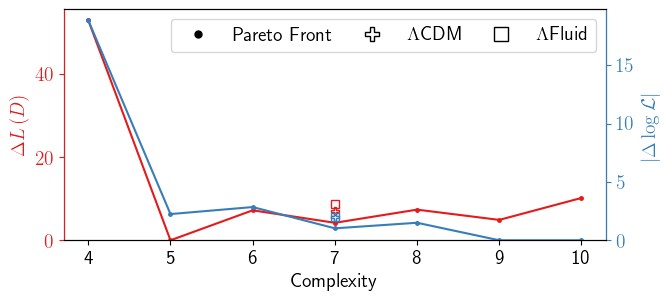

In [24]:
root_dirname = cc_like.like_dir + '/output/'
all_dirname = ['output_cc_dimful/']
line_labels = ['Cosmic Chronometers']
all_dirname = [root_dirname + d for d in all_dirname]
all_all_compl = [np.arange(4, 11), np.arange(4, 11)]

all_twocomp_eq = ['a0 + a1*pow(x,a2)', 'a0 + a1*pow(x,a2)']
all_lcdm_eq = ['a0 + a1*x**3', 'a0 + a1*x**3']

fig, axs1 = plt.subplots(1, 1, figsize=(7, 3), sharex=True)
axs1 = [axs1]
axs2 = [ax.twinx() for ax in axs1]
cm = plt.get_cmap('Set1')
all_var_idx = [0, 2]

labels = ["+", "a0", "*", "a1", "pow", "x", "3"]
basis_functions = [["x", "a"],  # type0
                ["inv"],  # type1
                ["+", "*", "-", "/", "pow"]]  # type2

try:
    logl_lcdm_cc, dl_lcdm_cc = fit_single.single_function(labels, basis_functions, cc_like, verbose=True)
except:
    logl_lcdm_cc, dl_lcdm_cc = None, None
try:
    logl_lcdm_panth, dl_lcdm_panth = fit_single.single_function(labels, basis_functions, panth_like, verbose=True)
except:
    logl_lcdm_panth, dl_lcdm_panth = None, None
logl_lcdm7 = [logl_lcdm_cc, logl_lcdm_panth]
dl_lcdm7 = [dl_lcdm_cc, dl_lcdm_panth]
lcdm_complexity = len(labels)

for dirname in all_dirname:
    
    for var_idx in [0, 2]:
        
        if var_idx == 0:
            print('\nDL')
        else:
            print('\nlogL')
    
        print(dirname)

        twocomp_eq = all_twocomp_eq[all_dirname.index(dirname)]
        lcdm_eq = all_lcdm_eq[all_dirname.index(dirname)]
        all_compl = all_all_compl[all_dirname.index(dirname)]

        res = []
        fun = []
        params = []
        store_comp = []

        for i, compl in enumerate(all_compl):
            fname = dirname + 'final_%i.dat'%compl
            with open(fname, "r") as f:
                reader = csv.reader(f, delimiter=';')
                data = [row for row in reader]

                res += [d[2:7] for d in data]
                fun += [d[1] for d in data]
                params += [d[7:] for d in data]
                store_comp += [compl] * len(data)

        res = np.array(res, dtype=float)
        params = np.array(params, dtype=float)
        store_comp = np.array(store_comp, dtype=int)
        
        # Replace LCDM by complexity 7 version
        lcdm_idx = fun.index(lcdm_eq)
        if var_idx == 0:
            res[lcdm_idx,var_idx] = min(dl_lcdm7[all_dirname.index(dirname)],res[lcdm_idx,var_idx])
            store_comp[lcdm_idx] = lcdm_complexity   
        elif var_idx == 2:
            res[lcdm_idx,var_idx] = min(logl_lcdm7[all_dirname.index(dirname)],res[lcdm_idx,var_idx])
            store_comp[lcdm_idx] = lcdm_complexity  

        # Sort by DL
        m = np.argsort(res[:,var_idx], kind='stable')
        res = res[m,:]
        params = params[m,:]
        store_comp = store_comp[m]
        fun = [fun[i] for i in m]
        
        # Remove duplicates by likelihood
        _, uniq_idx = np.unique(res[:,2], return_index=True)
        uniq_idx = np.sort(uniq_idx)
        fun = [fun[i] for i in uniq_idx]
        res = res[uniq_idx,:]
        store_comp = store_comp[uniq_idx]
        params = params[uniq_idx,:]
        
        # Remove duplicates by name
        new_fun = []
        uniq_idx = []
        got_comp = [False]*(all_compl.max()+1)
        for i in range(len(fun)):
            if fun[i] not in new_fun:
                uniq_idx.append(i)
                new_fun.append(fun[i])
                got_comp[store_comp[i]] = True
                if all(got_comp[all_compl.min():all_compl.max()]) == True:
                    break
        print(len(fun), len(new_fun))
        fun = new_fun
        res = res[uniq_idx,:]
        store_comp = store_comp[uniq_idx]
        params = params[uniq_idx,:]

        twocomp_idx = fun.index(twocomp_eq)
        lcdm_idx = fun.index(lcdm_eq)
        
        # Print where LCDM and twocomp came
        print("LCDM CAME:", lcdm_idx+1)
        print("TWOCOMP CAME:", twocomp_idx+1)

        # Don't need to go higher than this
        idx = [store_comp.tolist().index(c) for c in all_compl]
        best_DL = [res[i,var_idx] for i in idx]
        lcdm_DL = res[lcdm_idx, var_idx]
        twocomp_DL = res[twocomp_idx, var_idx]
        
        # Subtract the best
        MDL = min(best_DL)
        best_DL = [d - MDL for d in best_DL]
        lcdm_DL -= MDL
        twocomp_DL -= MDL
        
        print("LCDM:", lcdm_DL, "FLUID", twocomp_DL)
        
        for i, c in enumerate(all_compl):
            print(c, best_DL[i])

        i = all_dirname.index(dirname)
        j = all_var_idx.index(var_idx)
        if j == 0:
            axs1[i].plot(all_compl, best_DL, marker='.', color=cm(j), markersize=5)
            axs1[i].plot(store_comp[lcdm_idx], lcdm_DL, 'P', color=cm(j), fillstyle='none')
            axs1[i].plot(store_comp[twocomp_idx], twocomp_DL, 's', color=cm(j), fillstyle='none')
        else:
            axs2[i].plot(all_compl, best_DL, marker='.', color=cm(j), markersize=5)
            axs2[i].plot(store_comp[lcdm_idx], lcdm_DL, 'P', color=cm(j), fillstyle='none')
            axs2[i].plot(store_comp[twocomp_idx], twocomp_DL, 's', color=cm(j), fillstyle='none')
            
for k in range(len(axs1)):
    axs1[k].set_ylabel(r'$\Delta L \left( D \right)$')
    axs2[k].set_ylabel(r'$ \left| \Delta \log\mathcal{L} \right|$')
    axs1[k].yaxis.label.set_color(cm(0))
    axs1[k].tick_params(axis='y', colors=cm(0))
    axs2[k].spines['left'].set_color(cm(0))

    axs2[k].yaxis.label.set_color(cm(1))
    axs2[k].tick_params(axis='y', colors=cm(1))
    axs2[k].spines['right'].set_color(cm(1))
    
    axs1[k].set_ylim(0, None)
    axs2[k].set_ylim(0, None)
    
#     axs1[k].set_title(line_labels[k], x=0.80, y=0.85)
    
legend_elements = [Line2D([0], [0], marker='.', color='k', label=r'Pareto Front',
                      markerfacecolor='k', markersize=10, lw=0),
               Line2D([0], [0], marker='P', color='k', label=r'$\Lambda$CDM',
                      markerfacecolor='k', markersize=10, lw=0, fillstyle='none'),
              Line2D([0], [0], marker='s', color='k', label=r'$\Lambda$Fluid',
                      markerfacecolor='k', markersize=10, lw=0, fillstyle='none')]
axs1[0].legend(handles=legend_elements,
               loc='upper right', 
               ncol=len(legend_elements), 
               columnspacing=1)
                       
axs1[0].set_xticks(all_compl)
axs1[0].set_xticklabels(all_compl)
    
axs1[-1].set_xlabel(r'Complexity')

fig.subplots_adjust(hspace=0.1)
fig.savefig('figs/poster_pareto_front.pdf', bbox_inches='tight', transparent=True)